In [17]:
'''
based on param_estim.ipynb
'''

'\nbased on param_estim.ipynb\n'

In [18]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
from mpl_tools import is_notebook_or_qt as nb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import dapper as dpr
import dapper.da_methods as da
import dapper.mods as modelling
import dapper.tools.liveplotting as LP
from dapper.mods.PyCLES.minimal1D import *

In [20]:
# #### DA methods configurations

xps = dpr.xpList()
# xps += da.PartFilt(N=1000, reg=1)  # works OK with Nx=6
for N in [20]: # >= 2 as we need N-1 for variances
    xps += da.EnKF('Sqrt', N, infl=1.04)
    # xps += da.EnKF_N(N, xN=2)
    # for Lag in [1, 4, 20]:
        # xps += da.iEnKS("Sqrt", N, Lag=Lag, xN=2, wtol=1e-5)

In [21]:
### check obs
# direct obs of the state, adding obs noise
HMM, xx, yy = set_X0_and_simulate(HMM,xps[0])
xx, yy

Truth & Obs:   0%|          | 0/1 [00:00<?, ?it/s]

(array([[ 0.43890283, -1.        ,  2.        ],
        [-1.23212056, -1.        ,  2.        ]]),
 array([array([-1.29726046])], dtype=object))

In [22]:
# #### Launch experiments

scriptname = "minimal" if nb else __file__
save_as = xps.launch(
    HMM, scriptname, setup=set_X0_and_simulate,
    mp=False,           # Multiprocessing
    fail_gently=False,  # Facilitate debugging
    liveplots=False,    # NB: Turn off if running iEnKS
    free=False,         # Don't delete time series (enables replay)
)

Experiment gets stored at /home/dgrund/dpr_data/minimal/run_2024-01-04__16-26-29


Truth & Obs:   0%|          | 0/1 [00:00<?, ?it/s]

EnKF:   0%|          | 0/1 [00:00<?, ?it/s]

In [23]:
# #### Show results

# Load data
xps = dpr.xpList(dpr.load_xps(save_as))

Loading 1 files from /home/dgrund/dpr_data/minimal/run_2024-01-04__16-26-29


Loading:   0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
print(xps.tabulate_avrgs([
    "rmse.state.a", "rmv.state.a",
    "rmse.param.a", "rmv.param.a",
]))

   |  rmse.state.a  1σ   rmv.state.a  1σ   rmse.param.a  1σ   rmv.param.a  1σ 
-  -  -----------------  ----------------  -----------------  ----------------
0  |       0.05411 ±nan       0.1038 ±nan         1.638 ±nan       0.9362 ±nan


In [25]:
# # Plots --- only for time series
# xps[-1].stats.replay(
#     # t1=0,
#     # t2=np.inf,
# )

In [26]:
def print_summary(xp):
    print('ANALYSIS')
    print(f'mean:\t{xp.stats.mu.a}')
    print(f'spread:\t{xp.stats.spread.a}')
    print()
    print('FORECAST')
    print(f'mean:\t{xp.stats.mu.f}')
    print(f'spread:\t{xp.stats.spread.f}')
print_summary(xps[0])
# expect: mean towards truth, spread reduction

ANALYSIS
mean:	[[-1.28623271 -1.28934777  0.36150169]]
spread:	[[0.10380578 0.40810615 0.93624492]]

FORECAST
mean:	[[ 1.65804332  0.04544466 -0.25246412]]
spread:	[[1.63397649 0.83706154 0.96233479]]


In [27]:
xp = xps[0]

m = np.squeeze(xp.stats.mu.a)
s = np.squeeze(xp.stats.spread.a)

POST_MEAN_PARAMS = m[Nx:]
POST_VAR_PARAMS = s[Nx:]

POST_MEAN_STATE = m[:Nx]
POST_VAR_STATE = s[:Nx]

In [28]:
# xps[0].stats.spread
# xps[0].stats.__dict__['mu']

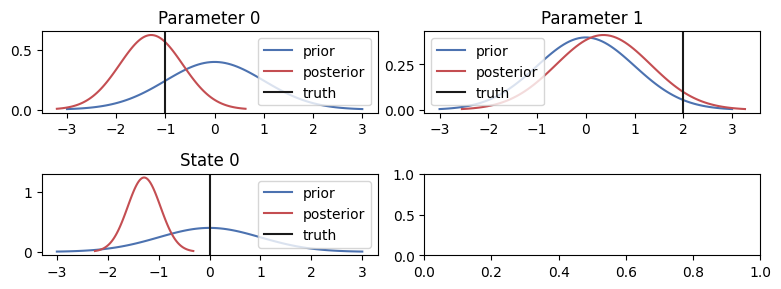

In [29]:
### Bayesian plot
# missing: obs and single ensemble members

import scipy.stats as stats
import matplotlib.pyplot as plt

# def plot_priors_params():
fig, axs = plt.subplots(2,Np, figsize=(max(Np,Nx)*4,3))

def plot_norm(ax,mu,var,label):
    sigma = np.sqrt(var)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    c = 'b' if label=='prior' else 'r'
    ax.plot(x, stats.norm.pdf(x, mu, sigma),c, label=label)
    

# params
for i in range(Np):
    plot_norm(axs[0,i],PRIOR_MEAN_PARAMS[i],PRIOR_VAR_PARAMS[0],'prior')
    plot_norm(axs[0,i],POST_MEAN_PARAMS[i],POST_VAR_PARAMS[i],'posterior')
    axs[0,i].axvline(TRUE_PARAMS[i],c='k', label='truth')
    axs[0,i].legend()
    axs[0,i].set_title(f'Parameter {i}')

# state
i = 0
plot_norm(axs[1,i],PRIOR_MEAN_STATE[i],PRIOR_VAR_STATE,'prior')
plot_norm(axs[1,i],POST_MEAN_STATE[i],POST_VAR_STATE,'posterior')
axs[1,0].axvline(TRUE_STATE[i],c='k', label='truth')
axs[1,0].legend()
axs[1,0].set_title(f'State {i}')

plt.tight_layout()
plt.show()

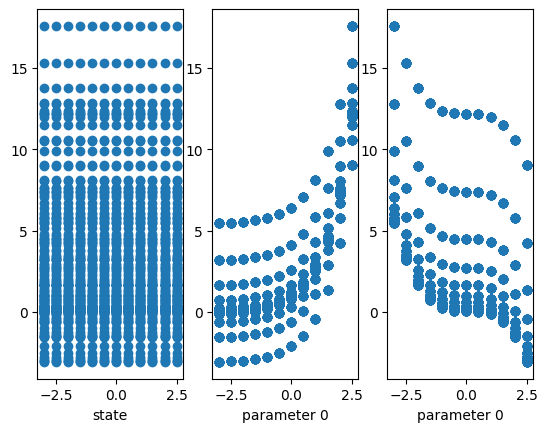

In [30]:
### sample target function
import itertools

space = np.arange(-3,3,0.5)
Ns = len(space)
result = []
for x,v,d in itertools.product(space,space,space):
    # print(x,v,d)
    result.append([x,v,d, call_dummy(x,[v,d],0,0)[0]])
result = np.array(result).T

fig,axs = plt.subplots(1,3)
axs[0].scatter(result[0], result[3])
axs[0].set_xlabel('state')

axs[1].scatter(result[1], result[3])
axs[1].set_xlabel('parameter 0')

axs[2].scatter(result[2], result[3])
axs[2].set_xlabel('parameter 0')

plt.show()

In [31]:
### sample obs likelihood

# sample x,v,d from prior/post and eval y -> spreads
# eval y separate for prior/post mean and truth -> means

# add to bayesian plot